## 1. Import Libraries

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import utils.utils as ut
%matplotlib inline

### 1.1. Import Tensorflow and Test GPU

Follow README.md for installation guidance

In [2]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU')[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 2. Import data

In [3]:
data = ut.import_data_info('./dataset', 'driving_log.csv')
print("Total Images: ", len(data))
print(data.head())

Total Images:  32443
                               Center                              Left  \
0  center_2019_04_02_19_25_33_671.jpg  left_2019_04_02_19_25_33_671.jpg   
1  center_2019_04_02_19_25_33_743.jpg  left_2019_04_02_19_25_33_743.jpg   
2  center_2019_04_02_19_25_33_816.jpg  left_2019_04_02_19_25_33_816.jpg   
3  center_2019_04_02_19_25_33_887.jpg  left_2019_04_02_19_25_33_887.jpg   
4  center_2019_04_02_19_25_33_959.jpg  left_2019_04_02_19_25_33_959.jpg   

                               Right  Steering  Throttle  Brake     Speed  
0  right_2019_04_02_19_25_33_671.jpg       0.0  0.000000    0.0  0.000011  
1  right_2019_04_02_19_25_33_743.jpg       0.0  0.000000    0.0  0.000007  
2  right_2019_04_02_19_25_33_816.jpg       0.0  0.000000    0.0  0.000003  
3  right_2019_04_02_19_25_33_887.jpg       0.0  0.048016    0.0  0.002267  
4  right_2019_04_02_19_25_33_959.jpg       0.0  0.281203    0.0  0.175589  


## 3. Get Balanced data

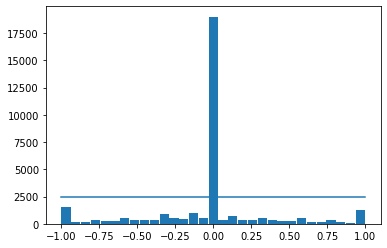

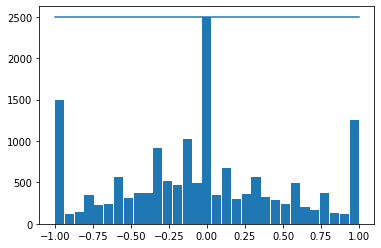

Removed data len:  16497
Remaining data len:  15946


In [4]:
data = ut.get_balance_data(data, True)

## 4. Data Preparation

### 4.1. Get Image Path Array

In [5]:
image_abs_paths, steering_values = ut.load_data('./dataset', data)
print(image_abs_paths, steering_values)

['/home/pranjal/Git/Self-Driving-Car/dataset/IMG/center_2019_04_02_19_25_33_671.jpg'
 '/home/pranjal/Git/Self-Driving-Car/dataset/IMG/center_2019_04_02_19_25_34_243.jpg'
 '/home/pranjal/Git/Self-Driving-Car/dataset/IMG/center_2019_04_02_19_25_35_092.jpg'
 ...
 '/home/pranjal/Git/Self-Driving-Car/dataset/IMG/center_2019_04_02_18_31_04_295.jpg'
 '/home/pranjal/Git/Self-Driving-Car/dataset/IMG/center_2019_04_02_18_31_04_500.jpg'
 '/home/pranjal/Git/Self-Driving-Car/dataset/IMG/center_2019_04_02_18_31_04_570.jpg'] [ 0.    0.   -0.15 ...  1.    0.    0.  ]


### 4.2. Split Train and Test data

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(image_abs_paths, steering_values, test_size=0.2, random_state=5)
print("Train data length: ", len(x_train))
print("Validation data length: ", len(x_val))

Train data length:  12756
Validation data length:  3190


## 5. Augmentation, Pre Processing and Batch Generation

In [7]:
import numpy as np

def batch_gen(image_paths, steering_list, batch_size, is_train: bool = True):
    while True:
        img_batch = []
        steering_batch = []
        
        for i in range(batch_size):
            index = np.random.randint(0, len(image_paths)-1)
            if is_train:
                # Augment only when Its training data
                img, steering = ut.augment_image(image_paths[index], steering_list[index])
            else:
                img, steering = ut.read_img(image_paths[index]), steering_list[index]
            img = ut.pre_process(img)
            img_batch.append(img)
            steering_batch.append(steering)
        yield np.asarray(img_batch), np.asarray(steering_batch)

## 6. Model Training

### 6.1. Define Model Params

In [8]:
params = {
    'learning_rate' : 0.0001,
    'loss_fn' : 'mse',
    'activation' : 'elu'
}

### 6.2. Create Model

In [9]:
model = ut.create_model(params) # Using loss function Mean Square Error
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

### 6.2. Create Checkpoint Callback to save Epoch data

Save intermediate Epoch data for safety purpose.

In [10]:
checkpoint_filepath = 'model/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

### 6.3. Train the model

In [11]:
try:
    batch_size = 500
    history = model.fit(batch_gen(x_train, y_train, batch_size, True),
                        batch_size=batch_size,
                        steps_per_epoch=50, 
                        epochs=100,
                        shuffle=True,
                        validation_data=batch_gen(x_val, y_val, batch_size, False), 
                        validation_steps=200, 
                        callbacks=model_checkpoint_callback,
                        use_multiprocessing=False)
except KeyboardInterrupt:
    pass
finally:
    model.save('model/model.h5')

Epoch 1/100


2021-07-12 21:33:51.544560: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-07-12 21:33:51.544591: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2021-07-12 21:33:51.544964: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-07-12 21:33:51.545040: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


50/50 [==============================] - 553s 10s/step - loss: 0.2708 - val_loss: 0.2294
Epoch 2/100
50/50 [==============================] - 286s 6s/step - loss: 0.2255 - val_loss: 0.2139
Epoch 3/100
50/50 [==============================] - 255s 5s/step - loss: 0.2126 - val_loss: 0.2014
Epoch 4/100
50/50 [==============================] - 250s 5s/step - loss: 0.2157 - val_loss: 0.2004
Epoch 5/100
50/50 [==============================] - 251s 5s/step - loss: 0.2077 - val_loss: 0.1899
Epoch 6/100
50/50 [==============================] - 251s 5s/step - loss: 0.2007 - val_loss: 0.1838
Epoch 7/100
50/50 [==============================] - 250s 5s/step - loss: 0.1902 - val_loss: 0.1704
Epoch 8/100
50/50 [==============================] - 250s 5s/step - loss: 0.1837 - val_loss: 0.1621
Epoch 9/100
50/50 [==============================] - 249s 5s/step - loss: 0.1807 - val_loss: 0.1504
Epoch 10/100
50/50 [==============================] - 251s 5s/step - loss: 0.1782 - val_loss: 0.1555
Epoch 11/1

In [12]:
try:
    batch_size = 500
    history_2 = model.fit(batch_gen(x_train, y_train, batch_size, True),
                        batch_size=batch_size,
                        steps_per_epoch=50, 
                        initial_epoch =100,
                        epochs=200,
                        validation_freq = 5,
                        shuffle=True,
                        validation_data=batch_gen(x_val, y_val, batch_size, False), 
                        validation_steps=200, 
                        callbacks=model_checkpoint_callback,
                        use_multiprocessing=False)
except KeyboardInterrupt:
    pass
finally:
    model.save('model/model.h5')

Epoch 101/200
50/50 [==============================] - 74s 1s/step - loss: 0.1081
Epoch 102/200
50/50 [==============================] - 75s 1s/step - loss: 0.1072
Epoch 103/200
50/50 [==============================] - 75s 1s/step - loss: 0.1046
Epoch 104/200
50/50 [==============================] - 250s 5s/step - loss: 0.1046 - val_loss: 0.0977
Epoch 105/200
50/50 [==============================] - 74s 2s/step - loss: 0.1046
Epoch 106/200
50/50 [==============================] - 75s 1s/step - loss: 0.1047
Epoch 107/200
50/50 [==============================] - 75s 1s/step - loss: 0.1062
Epoch 108/200
50/50 [==============================] - 255s 5s/step - loss: 0.1036 - val_loss: 0.0978
Epoch 109/200
50/50 [==============================] - 74s 2s/step - loss: 0.1041
Epoch 110/200
50/50 [==============================] - 75s 2s/step - loss: 0.1039
Epoch 111/200
50/50 [==============================] - 75s 2s/step - loss: 0.1043
Epoch 112/200
50/50 [==============================] - 252

50/50 [==============================] - 73s 1s/step - loss: 0.0971
Epoch 158/200
50/50 [==============================] - 74s 1s/step - loss: 0.0966
Epoch 159/200
50/50 [==============================] - 74s 1s/step - loss: 0.0961
Epoch 160/200
50/50 [==============================] - 250s 5s/step - loss: 0.0950 - val_loss: 0.0926
Epoch 161/200
50/50 [==============================] - 73s 1s/step - loss: 0.0963
Epoch 162/200
50/50 [==============================] - 75s 1s/step - loss: 0.0952
Epoch 163/200
50/50 [==============================] - 74s 1s/step - loss: 0.0956
Epoch 164/200
50/50 [==============================] - 250s 5s/step - loss: 0.0957 - val_loss: 0.0920
Epoch 165/200
50/50 [==============================] - 73s 1s/step - loss: 0.0961
Epoch 166/200
50/50 [==============================] - 74s 1s/step - loss: 0.0947
Epoch 167/200
50/50 [==============================] - 75s 1s/step - loss: 0.0952
Epoch 168/200
50/50 [==============================] - 257s 5s/step - lo

In [55]:
val_loss_data = [float("{:.4f}".format(val_loss)) for val_loss in history.history['val_loss']]
val_loss_data_2 = [float("{:.4f}".format(val_loss)) for val_loss in history_2.history['val_loss']]

for val in val_loss_data_2:
    for x in range(4):
        val_loss_data.append(val)
        
train_loss_data = [float("{:.4f}".format(loss)) for loss in history.history['loss']]
for loss in history_2.history['loss']:
    train_loss_data.append(loss)
    
val_acc_data = [float("{:.4f}".format(1 - val_loss)) for val_loss in val_loss_data]
train_acc_data = [float("{:.4f}".format(1 - val_loss)) for val_loss in train_loss_data]

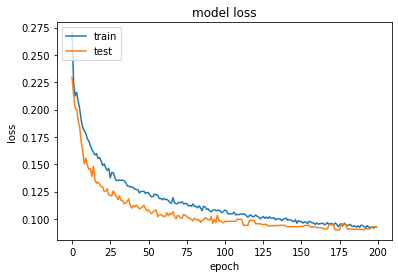

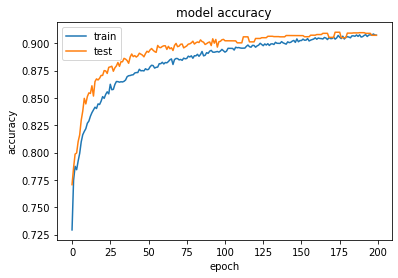

In [56]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(train_loss_data)
plt.plot(val_loss_data)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_acc_data)
plt.plot(val_acc_data)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()